# 정리
1. 몇 가지 기준으로 대상이 될 종목들을 가져온다
    - 시점 (매수 시점)에 따른 시가총액, 우선주 제외
2. change table에서 이 종목들의 대상 기간에 대한 가격정보를 가져온다
    - 대상 기간 (매수 고려 시점 : 매수 시점 - x개월) 에서의 누적 수익률을 계산한다.
3. 누적 수익률을 기준으로 종목을 분류한다.
4. 이를 반복하여 momentum 지표를 확인한다.

In [1]:
import pandas as pd
import FinanceDataReader as fdr
from datetime import datetime
from pykrx import stock
import re
from datetime import datetime
from collections import Counter
from dateutil.relativedelta import relativedelta
import math

In [2]:
import warnings
warnings.filterwarnings('ignore') # 경고메시지 무시하기

In [3]:
def date_str_bar (date):
    date_temp=str("%s-%02d-%02d" %(date.year, date.month, date.day))
    return date_temp
def date_str (date):
    date_temp=str("%s%02d%02d" %(date.year, date.month, date.day))
    return date_temp
def date_to_date (date):
    date = date.split('-')
    date_new = datetime(int(date[0]),int(date[1]),int(date[2]))
    return date_new

## 자료 불러오기

In [4]:
change= pd.read_csv('Raw_Price/change_all.csv',index_col=0)
close = pd.read_csv('Raw_Price/price_all.csv', index_col=0)
kospi_index = pd.read_csv('Raw_Price/kospi_index.csv',index_col=0)

finance_kospi = pd.read_csv('Raw_Finance/kospi_finance.csv',index_col=0).reset_index(drop=True)
finance_kospi['stock_code'] = finance_kospi['stock_code'].apply(lambda x : '%06d'%x)
# finance_kosdaq = pd.read_csv('Raw_Finance/kosdaq_finance.csv',index_col=0).reset_index(drop=True)
# finance_kosdaq['stock_code'] = finance_kosdaq['stock_code'].apply(lambda x : '%06d'%x)
# finance_del = pd.read_csv('Raw_Finance/del_finance.csv',index_col=0).reset_index(drop=True)
# finance_del['stock_code'] = finance_del['stock_code'].apply(lambda x : '%06d'%x)
finance_kospi_modi = pd.read_csv('Raw_Finance/kospi_finance_input_quarterly_data.csv',index_col=0).reset_index(drop=True)
finance_kospi_modi['stock_code'] = finance_kospi_modi['stock_code'].apply(lambda x : '%06d'%x)
# finance = pd.concat([finance_kospi,finance_kosdaq,finance_del],axis=0)


In [5]:
finance_naver = pd.read_csv('Raw_Finance/finance_naver_converted.csv',index_col=0).reset_index(drop=True)
finance_naver['stock_code'] = finance_naver['stock_code'].apply(lambda x : '%06d'%x)

## input_quarterly_data함수 수정 필요
- 함수가 너무 느리고, finance_All에 적용했더니 오류 발생

In [860]:
finance_modi = input_quarterly_data(finance)

In [862]:
finance_modi.to_csv('Raw_Finance/finance_input_quarterly_data.csv',encoding='utf-8-sig')

In [4]:
def input_quarterly_data (data : pd.DataFrame):
#     stock_code_list = data.stock_code
    stock_code_list = list(dict.fromkeys(data.stock_code))
#     period_list = list(dict.fromkeys(data.period))
    for stock_code in stock_code_list:
        finance_by_stock = data[data['stock_code']== stock_code]
        period_list = finance_by_stock.period
        for period in period_list:
#             if period in finance_by_stock.period:
            if str(period)[4:6]!='12':
        #         print(period)
                for col in finance_by_stock.columns[2:]:
                    period_last = int(str(period-100)[0:4]+'12')
#                     print(col, period, period_last)
                    index_no = data[(data['period'] == period)&(data['stock_code'] == stock_code)].index[0]
                    if period_last in list(finance_by_stock.period):
                        index_no_last = finance_by_stock[finance_by_stock['period'] == period_last].index[0]
                    if np.isnan(finance_by_stock[finance_by_stock['period'] == period][col].values) & (len(finance_by_stock[finance_by_stock['period'] == period_last][col]) != 0):
        #                 index_no = finance_by_stock[finance_by_stock['period'] == period].index
                        data.at[index_no,col] = finance_by_stock.at[index_no_last,col]
            else:
                for quarter in ['03','06','09']:
                    period_quarter = int(str(period+100)[0:4]+quarter)
                    if not period_quarter in list(period_list):
#                         print(period_quarter)
                        df_period_quarter = finance_by_stock[finance_by_stock.period == period]
                        df_period_quarter.period = period_quarter
                        data = data.append(df_period_quarter)
    return data

In [866]:
input_quarterly_data(temp)

,stock_code,period,총자산,현금,부채,지배자산,매출액,매출원가,매출총이익,판관비,영업이익,당기순이익,지배순이익,영업활동현금흐름
0,000020,202103,4.372693e+11,5.890616e+10,9.606559e+10,3.296506e+11,2.768989e+11,1.342833e+11,1.426157e+11,9.966666e+10,2.556582e+10,3.196671e+10,3.169340e+10,3.846881e+10
1,000020,202012,4.338078e+11,5.859643e+10,9.112556e+10,3.312555e+11,2.720754e+11,1.334094e+11,1.386660e+11,9.860051e+10,2.315337e+10,2.871510e+10,2.850769e+10,5.222823e+10
2,000020,202009,4.245615e+11,7.239734e+10,9.229299e+10,3.256000e+11,2.867462e+11,1.500011e+11,1.367451e+11,9.602175e+10,2.356772e+10,2.839715e+10,2.840519e+10,4.644059e+10
3,000020,202006,3.882905e+11,1.114818e+11,7.710188e+10,3.111886e+11,2.943950e+11,1.637952e+11,1.305998e+11,9.655638e+10,1.705682e+10,1.687545e+10,1.688353e+10,4.423788e+10
4,000020,202003,3.761859e+11,7.573369e+10,7.669876e+10,2.994871e+11,2.994903e+11,1.760521e+11,1.234382e+11,9.688905e+10,9.968394e+09,9.524724e+09,9.532891e+09,3.235969e+10
5,000020,201912,3.763575e+11,3.777918e+10,7.664909e+10,2.997084e+11,3.071500e+11,1.855535e+11,1.215965e+11,9.571355e+10,9.550751e+09,9.107598e+09,9.115975e+09,1.328497e+10
6,000020,201909,3.747781e+11,4.020126e+10,8.065691e+10,2.941212e+11,2.991952e+11,1.817343e+11,1.174609e+11,9.651676e+10,4.399054e+09,3.993875e+09,4.000576e+09,1.056089e+10
7,000020,201906,3.760705e+11,2.968667e+10,8.188507e+10,2.941855e+11,2.998929e+11,1.830360e+11,1.168569e+11,9.526596e+10,5.271003e+09,4.937999e+09,4.942678e+09,3.123135e+09
8,000020,201903,3.722708e+11,3.418897e+10,7.572410e+10,2.962393e+11,3.043018e+11,1.878482e+11,1.164536e+11,9.356240e+10,6.973048e+09,6.318979e+09,6.321563e+09,-1.432660e+10
9,000020,201812,3.708474e+11,4.061451e+10,7.432673e+10,2.962111e+11,3.066026e+11,1.910352e+11,1.155674e+11,8.972801e+10,1.009765e+10,9.188167e+09,9.188561e+09,-4.360078e+09


In [865]:
temp = finance[finance.stock_code == '000020']

In [863]:
finance_modi[finance_modi.stock_code == '000020'] #code가 문제가 있는듯?

,stock_code,period,총자산,현금,부채,지배자산,매출액,매출원가,매출총이익,판관비,영업이익,당기순이익,지배순이익,영업활동현금흐름
0,000020,202103,4.372693e+11,5.890616e+10,9.606559e+10,3.296506e+11,2.768989e+11,1.342833e+11,1.426157e+11,9.966666e+10,2.556582e+10,3.196671e+10,3.169340e+10,3.846881e+10
1,000020,202012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.860051e+10,2.315337e+10,NaN,NaN,NaN
2,000020,202009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.602175e+10,2.356772e+10,NaN,NaN,NaN
3,000020,202006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.655638e+10,1.705682e+10,NaN,NaN,NaN
4,000020,202003,3.761859e+11,7.573369e+10,7.669876e+10,2.994871e+11,2.994903e+11,1.760521e+11,1.234382e+11,9.688905e+10,9.968394e+09,9.524724e+09,9.532891e+09,3.235969e+10
5,000020,201912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.571355e+10,9.550751e+09,NaN,NaN,NaN
6,000020,201909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.651676e+10,4.399054e+09,NaN,NaN,NaN
7,000020,201906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.526596e+10,5.271003e+09,NaN,NaN,NaN
8,000020,201903,3.722708e+11,3.418897e+10,7.572410e+10,2.962393e+11,3.043018e+11,1.878482e+11,1.164536e+11,9.356240e+10,6.973048e+09,6.318979e+09,6.321563e+09,-1.432660e+10
9,000020,201812,NaN,NaN,NaN,2.969447e+11,NaN,NaN,NaN,8.972801e+10,1.009765e+10,NaN,4.700901e+10,NaN


## 대상 종목 선정하기

In [6]:
# 특정 시점에 시가총액, 거래대금 기준으로 대상이 되는 종목 list up
def make_stock_list_by_date (date : datetime, cap : int=10000000000,trade : int=100000000)->list:
    date = date_str(date)
    df_cap_kospi = stock.get_market_cap_by_ticker(date,market='KOSPI')
    df_cap_kosdaq = stock.get_market_cap_by_ticker(date, market='KOSDAQ')
    df_cap = pd.concat([df_cap_kospi,df_cap_kosdaq], axis=0)
    
    df_cap = df_cap[lambda df_cap : df_cap['시가총액'] > np.int64(cap)] #시가총액 100억 이상
    df_cap = df_cap[lambda df_cap : df_cap['거래대금'] > np.int64(trade)] #거래대금 1억 이상
    total_list = df_cap.index
    list_temp=[]
    p=re.compile('[0-9]*5$|[0-9]*7$|[0-9]*9$|[0-9]*K$|[0-9]*L$|[0-9]*M$|[0-9]*B$')
    for i in total_list:
        if not p.match(i):
            list_temp.append(i)
    return list_temp

In [7]:
def make_stock_list_by_date_cap (date : datetime, cap : int=10000000000,trade : int=100000000)->list:
    date = date_str(date)
    df_cap_kospi = stock.get_market_cap_by_ticker(date,market='KOSPI')
    df_cap_kosdaq = stock.get_market_cap_by_ticker(date, market='KOSDAQ')
    df_cap = pd.concat([df_cap_kospi,df_cap_kosdaq], axis=0)
    
    df_cap = cap_add_preferred(df_cap)
    
    df_cap = df_cap[lambda df_cap : df_cap['시가총액'] > np.int64(cap)] #시가총액 100억 이상
    df_cap = df_cap[lambda df_cap : df_cap['거래대금'] > np.int64(trade)] #거래대금 1억 이상
    df_cap = df_cap.sort_values(by='시가총액',ascending=False) #시가총액 높은게 먼저
    total_list = df_cap.index
    list_temp=[]
    p=re.compile('[0-9]*5$|[0-9]*7$|[0-9]*9$|[0-9]*K$|[0-9]*L$|[0-9]*M$|[0-9]*B$')
    for i in total_list:
        if not p.match(i):
            list_temp.append(i)
    return list_temp

In [8]:
# 시가총액의 df에서 우선주의 시가총액을 고려한 시가총액 으로 변경
def cap_add_preferred (df_cap : pd.DataFrame ):
    df_cap['시가총액수정'] = df_cap['시가총액']
    # 우선주 리스트 만들기
    p=re.compile('[0-9]*5$|[0-9]*7$|[0-9]*9$|[0-9]*K$|[0-9]*L$|[0-9]*M$|[0-9]*B$')
    stock_list_preferred = []
    for i in df_cap.index:
        if p.match(i):
            stock_list_preferred.append(i)
    # 우선주의 시가총액을 보통주에 더하기        
    for stock_code in stock_list_preferred:
        stock_code_common = stock_code[0:5]+'0'
        df_cap.loc[stock_code_common,'시가총액수정'] = df_cap.loc[stock_code_common,'시가총액수정'] + df_cap.loc[stock_code,'시가총액']
    df_cap['시가총액'] = df_cap['시가총액수정']
    df_cap.drop(columns=['시가총액수정'],inplace=True)
    return df_cap

In [9]:
# 대상 종목을 대상 기간동안의 수익률 기준으로 오름차순 정렬
def make_stock_list_by_yield (stocks : list, bgn : datetime, end : datetime) -> list:
    change_stocks = change[stocks]
    yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
    yield_stocks = yield_stocks.dropna(axis=1) #그 기간 중 상장한 경우 결측치로 나와 결측치를 제거함.
    stock_list = yield_stocks.T.sort_values(by=yield_stocks.index[0],ascending=True)
    return stock_list.index

In [10]:
#ID (정보이산) = sign(과거수익률) x [마이너스 수익률 비중(%)-플러스 수익률 비중(%)]
def make_stock_list_by_discrete (stocks : list, bgn : datetime, end : datetime) -> list:
    change_stocks = change[stocks]
    # sign(PERT) 를 계산하는 것은 2m-12m
    yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
    yield_stocks = yield_stocks.dropna(axis=1) #그 기간 중 상장한 경우 결측치로 나와 결측치를 제거함.
    sign_stocks = yield_stocks.T[yield_stocks.index[0]].apply(lambda x:1 if x>1 else -1)
    
    # %neg-%pos 를 계산하는 것은 1m-12m (?) -> 아직은 2m-12m으로 함수구성됨.
    yield_count = change[yield_stocks.columns].loc[date_str_bar(bgn):date_str_bar(end),:]
    for i in yield_count.columns:
        yield_count[i] = yield_count[i].apply(lambda x: -1 if x>0 else 1)
    yield_count = yield_count.sum(axis=0)
    
    yield_id = pd.concat([pd.DataFrame(sign_stocks) ,pd.DataFrame(yield_count)],axis=1)
    yield_id['ID'] = yield_id[yield_id.columns[0]]*yield_id[yield_id.columns[1]]/len(yield_stocks.columns)
    stock_list = yield_id.sort_values(by='ID',ascending=False)
    return stock_list.index

## 대상기간의 가격정보 가져오기

In [11]:
def cal_yield_by_stock(stocks : list, bgn : datetime, end : datetime) -> float:
    change_stocks = change[stocks]
    yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
    yield_sum = (yield_stocks.T.sum() / len(stocks)).values[0]
    return yield_sum

In [167]:
# 종목 list와 각 종목의 비중 list를 넣으면 수익률과 최종 비중이 나옴.
def cal_yield_by_stock_daily_and_portion (stocks : list, portions : list, bgn : datetime, end : datetime):
    if 'cash' in stocks:
        cashPortion = portions.pop(stocks.index('cash'))
        stocks.remove('cash')
        change_stocks = change[stocks[:]]
        yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).fillna(0).cumprod()
        for i in range(len(yield_stocks.columns)):
            yield_stocks[yield_stocks.columns[i]] = yield_stocks[yield_stocks.columns[i]]*portions[i]
        yield_stocks['cash'] = cashPortion
    else:
        change_stocks = change[stocks]
        yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).fillna(0).cumprod()
        for i in range(len(yield_stocks.columns)):
            yield_stocks[yield_stocks.columns[i]] = yield_stocks[yield_stocks.columns[i]]*portions[i]
    
    yield_sum = yield_stocks.sum(axis=1)
    yield_list_temp = []
    yield_list_temp.append(yield_sum.values[0])
    for i in range(len(yield_sum.values)-1):
        yield_list_temp.append(yield_sum.values[i+1] / yield_sum.values[i])
    return pd.DataFrame(data=yield_list_temp,index=yield_sum.index), yield_stocks.to_dict('records')[-1]

In [12]:
def cal_yield_by_stock_daily(stocks : list, bgn : datetime, end : datetime) :
#     print(date_str_bar(end))
    change_stocks = change[stocks]
    yield_sum = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).fillna(0).cumprod().sum(axis=1)/len(stocks) #상장폐지 종목이 있을경우 전부 손실로 반영하기 위해 fillna(0)추가, bgn시점 이후에 상장 된 종목은 포함되지 않을 거기때문에 기간 중 신규상장이 포함되어서 0으로 고려되는 문제는 없을 듯.
    yield_list_temp = []
    yield_list_temp.append(yield_sum.values[0])
    for i in range(len(yield_sum.values)-1):
        yield_list_temp.append(yield_sum.values[i+1] / yield_sum.values[i])
    
#     yield_sum = (yield_stocks.T.sum() / len(stocks)).values[0]
    return pd.DataFrame(data=yield_list_temp,index=yield_sum.index)

In [13]:
# 일별 기간의 수익률을 나타내는데, 각 종목의 이평선보다 낮은 값이면 매도 후 현금 보유
def cal_yield_by_stock_daily_and_sell_by_stock_ma(stocks : list, bgn : datetime, end : datetime, days_for_ma : int=60):
    change_stocks = change[stocks]
    #평가할 수 있는 함수 추가. 대상이 아니면 제외.
    close_stocks = close[stocks].loc[:date_str_bar(bgn)].tail(days_for_ma+10)
    not_buy_list = []
    for stock_code in close_stocks.columns:
        if close_stocks[stock_code][-2] < close_stocks[stock_code].rolling(days_for_ma).mean()[-2]: # [-1]은 bgn이므로 그보다 하루 전인 [-2]로 매수/매도 결정
            not_buy_list.append(stock_code)
    # 제외대상이면 change_stocks[제외대상] = 0
    if not len(not_buy_list) == 0:
        change_stocks[not_buy_list] = 0

    yield_sum = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).fillna(0).cumprod().sum(axis=1)/len(stocks)
    yield_list_temp = []
    yield_list_temp.append(yield_sum.values[0])
    for i in range(len(yield_sum.values)-1):
        yield_list_temp.append(yield_sum.values[i+1] / yield_sum.values[i])
    return pd.DataFrame(data=yield_list_temp,index=yield_sum.index)

In [14]:
# momentum_score_active (모멘텀 스코어의 비중대로 종목 비중 결정)
def cal_yield_by_stock_daily_and_momentum_score_active(stocks : list, bgn : datetime, end : datetime):
#     print(len(stocks))
    change_stocks = change[stocks]
    # 평가할 수 있는 내용 추가
    momentum_score = [0]*len(stocks)
#     print(len(momentum_score))
    close_stocks = close.loc[:date_str_bar(bgn),stocks]
    for i in range(12):
        price_subtraction_list = (close_stocks.iloc[-1,:] - close_stocks.iloc[-1-20*(i+1),:]).to_list()
        price_subtraction_list = [1 if i>0 else 0 for i in price_subtraction_list]
        momentum_score = [a+b for a,b in zip(momentum_score,price_subtraction_list)]
#     print(momentum_score)
#     print(len(momentum_score))
#     print(sum(momentum_score))
#     print(len(stocks), stocks)
#     print(len(change_stocks.columns), change_stocks.columns)

    change_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).fillna(0).cumprod()
    for i in range(len(stocks)):
#         print('count : ',i)
#         print(change_stocks[stocks[i]])
#         print(momentum_score[i])
        change_stocks[change_stocks.columns[i]] = change_stocks[change_stocks.columns[i]] * momentum_score[i] / sum(momentum_score)
#         print(change_stocks[stocks[i]])
#     print(change_stocks)
    yield_sum = change_stocks.sum(axis=1) #상장폐지 종목이 있을경우 전부 손실로 반영하기 위해 fillna(0)추가, bgn시점 이후에 상장 된 종목은 포함되지 않을 거기때문에 기간 중 신규상장이 포함되어서 0으로 고려되는 문제는 없을 듯.
    yield_list_temp = []
    yield_list_temp.append(yield_sum.values[0])
    for i in range(len(yield_sum.values)-1):
        yield_list_temp.append(yield_sum.values[i+1] / yield_sum.values[i])
    
    return pd.DataFrame(data=yield_list_temp,index=yield_sum.index)

In [40]:
# momentum_score_defensive (모멘텀 스코어의 비중대로 종목별 equal 중 모멘텀 스코어만큼만 매수)
def cal_yield_by_stock_daily_and_momentum_score_defensive(stocks : list, bgn : datetime, end : datetime):
    change_stocks = change[stocks]
    # 평가할 수 있는 내용 추가
    momentum_score = [0]*len(stocks)
    close_stocks = close.loc[:date_str_bar(bgn),stocks]
    for i in range(12):
        price_subtraction_list = (close_stocks.iloc[-1,:] - close_stocks.iloc[-1-20*(i+1),:]).to_list()
        price_subtraction_list = [1 if i>0 else 0 for i in price_subtraction_list]
        momentum_score = [a+b for a,b in zip(momentum_score,price_subtraction_list)]

    trade_portion = sum(momentum_score) / (12*len(stocks)) # 이만큼만 매수에 활용됨.
#     print(bgn, trade_portion)
    
    change_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).fillna(0).cumprod()
    for i in range(len(stocks)):
        change_stocks[change_stocks.columns[i]] = change_stocks[change_stocks.columns[i]] * momentum_score[i] / (12*len(stocks))
    # 전체가 1일때 현금의 비율을 모든 일자에 더해줌.
    change_stocks['cash'] = 1-trade_portion
    yield_sum = change_stocks.sum(axis=1) #상장폐지 종목이 있을경우 전부 손실로 반영하기 위해 fillna(0)추가, bgn시점 이후에 상장 된 종목은 포함되지 않을 거기때문에 기간 중 신규상장이 포함되어서 0으로 고려되는 문제는 없을 듯.
#     print(change_stocks)
    yield_list_temp = []
    yield_list_temp.append(yield_sum.values[0])
    for i in range(len(yield_sum.values)-1):
        yield_list_temp.append(yield_sum.values[i+1] / yield_sum.values[i])
    
    return pd.DataFrame(data=yield_list_temp,index=yield_sum.index)

In [172]:
# momentum_score_defensive_extract (모멘텀 스코어의 비중대로 종목별 equal 중 모멘텀 스코어만큼만 매수)
def cal_portion_by_momentum_score_defensive(stocks : list, bgn : datetime, end : datetime):
#     stocks = list(stocks)
    # 평가할 수 있는 내용 추가
    momentum_score = [0]*len(stocks)
    close_stocks = close.loc[:date_str_bar(bgn),stocks]
    months = 12
    for i in range(months):
        price_subtraction_list = (close_stocks.iloc[-1,:] - close_stocks.iloc[-1-20*(i+1),:]).to_list()
        price_subtraction_list = [1 if i>0 else 0 for i in price_subtraction_list]
        momentum_score = [a+b for a,b in zip(momentum_score,price_subtraction_list)]

    momentum_score = list(np.array(momentum_score) / (months*len(stocks)))
    # cash portion 추가
    stocks.append('cash')
    momentum_score.append(1-sum(momentum_score))
    return stocks, momentum_score

In [61]:
bgn = datetime(2021,1,1)
end = datetime(2021,2,1)
stocks = ['000660','005930','000220']
a,b = cal_yield_by_stock_daily_and_momentum_score_defensive_extract(stocks=stocks,bgn=bgn,end=end)
b

{'000660': 0.3516174402250354,
 '005930': 0.3415637860082306,
 '000220': 0.1994076420046333,
 'cash': 0.11111111111111116}

In [161]:
bgn = datetime(2021,1,1)
end = datetime(2021,2,1)
stocks = ['000660','005930','000220','000120','000270','000300','000320']
# por_temp = cal_portion_by_momentum_score_defensive(stocks=stocks,bgn=bgn,end=end)
# a,b = cal_yield_by_stock_daily_and_portion(stocks=stocks,portions= por_temp, bgn=bgn,end=end)
a,b = cal_portion_by_momentum_score_defensive_and_keeping_momentum(stocks=stocks,stocks_last=d, bgn=bgn,end=end)
print(a)
print(b)

['000220', '000120', 'cash', '000660', '005930']
[0.10350625103858149, 0.1293828137982269, 0.07762968827893613, 0.3516174402250354, 0.3415637860082306]


In [159]:
b

[0.10350625103858149,
 0.1293828137982269,
 0.3516174402250354,
 0.3415637860082306]

In [163]:
c,e = cal_yield_by_stock_daily_and_portion(a,b,bgn=bgn,end=end)
print(c)
print(e)

                   0
Date                
2021-01-04  1.034247
2021-01-05  1.023005
2021-01-06  0.995967
2021-01-07  1.011815
2021-01-08  1.029310
2021-01-11  0.989898
2021-01-12  0.988308
2021-01-13  1.008081
2021-01-14  0.993508
2021-01-15  0.983271
2021-01-18  0.986147
2021-01-19  1.011795
2021-01-20  1.004301
2021-01-21  1.008193
2021-01-22  0.988331
2021-01-25  1.030403
2021-01-26  0.970719
2021-01-27  0.993160
2021-01-28  0.978461
2021-01-29  0.983931
2021-02-01  1.014479
{'000220': 0.09287971853554423, '000120': 0.1329007755027105, '000660': 0.37090447281121897, '005930': 0.3499974597368291, 'cash': 0.07762968827893613}


In [166]:
# keeping_momentum (모멘텀 스코어의 비중대로 종목별 equal 중 모멘텀 스코어만큼만 매수)
def cal_portion_by_momentum_score_defensive_and_keeping_momentum(stocks : list, stocks_last : dict, bgn : datetime, end : datetime):
    # stock_last와 stock_last를 비교해서 동일하면 그대로 memontum_score_defensive 실시
    if len(stocks_last) == 0:
        stocks_new, portion_new = cal_portion_by_momentum_score_defensive(stocks=stocks,bgn=bgn, end=end)
    else:
        # 지난번 매수한 종목 중 현재 수익률이 + 라면 유지.
        stocks_with_momentum = []
#         close_stocks = close.loc[:date_str_bar(bgn),list(stocks_last.keys())]
        for stock_code in list(stocks_last.keys()):
            if stock_code == 'cash':
                continue
            close_stocks = close.loc[:date_str_bar(bgn),[stock_code]]
            last_close_price = close_stocks[stock_code][-21]
            if not math.isnan(last_close_price): # 20일 전 가격이 없으면 제외
                if close_stocks[stock_code][-1] > last_close_price:
                    if stocks_last[stock_code] > 1/len(stocks): # 너무 적게 있으면 유지하는 것보다 리밸런싱할때 추가로 기본만큼 매수하는게 낫다.
                        stocks_with_momentum.append(stock_code)
        
        # 새로 매수해야하는 주식의 분율 (전체가 1)
        portion_new_all = sum(stocks_last.values())-sum([stocks_last[stock] for stock in stocks_with_momentum])
        stocks_no_new = int(portion_new_all // (1/len(stocks)))
        for stock in stocks_with_momentum:
            stocks.remove(stock)
        stocks_new = stocks[:stocks_no_new].copy()
        stocks_new, portion_new = cal_portion_by_momentum_score_defensive(stocks=stocks_new, bgn=bgn, end=end)
        portion_new = list(np.array(portion_new) * portion_new_all)
        
        # 현금 고려, new를 portion_new_all로 나눠주기
        
        # stocks_with_momentum과 합치기
        for stock in stocks_with_momentum:
            stocks_new.append(stock)
            portion_new.append(stocks_last[stock])
    return stocks_new, portion_new

In [64]:
a = {1:2}
len(a)

1

In [181]:
bgn = datetime(2021,1,1)
end = datetime(2021,2,1)
stocks = ['000660','005930','000220']
cal_yield_by_stock_daily_and_momentum_score_defensive(stocks=stocks,bgn=bgn,end=end)

2021-01-01 00:00:00 0.8888888888888888
              000660    005930    000220      cash
Date                                              
2021-01-04  0.354430  0.341564  0.216885  0.111111
2021-01-05  0.367089  0.345267  0.216885  0.111111
2021-01-06  0.368495  0.338272  0.228322  0.111111
2021-01-07  0.378340  0.341152  0.222222  0.111111
2021-01-08  0.388186  0.365432  0.216123  0.111111
2021-01-11  0.374121  0.374486  0.209290  0.111111
2021-01-12  0.362869  0.372840  0.207765  0.111111
2021-01-13  0.374121  0.369136  0.211577  0.111111
2021-01-14  0.367089  0.369136  0.211577  0.111111
2021-01-15  0.358650  0.362140  0.210815  0.111111
2021-01-18  0.365682  0.349794  0.203191  0.111111
2021-01-19  0.367089  0.358025  0.202428  0.111111
2021-01-20  0.367089  0.358848  0.207003  0.111111
2021-01-21  0.369902  0.362551  0.207765  0.111111
2021-01-22  0.361463  0.357202  0.208528  0.111111
2021-01-25  0.379747  0.367901  0.210815  0.111111
2021-01-26  0.362869  0.356790  0.209290  0

,0
Date,
2021-01-04,1.023990
2021-01-05,1.015979
2021-01-06,1.005620
2021-01-07,1.006334
2021-01-08,1.026619
2021-01-11,0.989042
2021-01-12,0.986508
2021-01-13,1.010772
2021-01-14,0.993403


In [165]:
def cal_yield_by_stock_rebal (stocks : list, bgn : datetime, duration : int, rebalance : bool = True, stock_weight : str = 'equal',stocks_last : dict={}): # relancing안하는 기준도 함수 추가.
    df_yield = pd.DataFrame()
    if rebalance is True:
        for month in range(duration):
            bgn_temp = bgn + relativedelta(months = month)
            end_temp = bgn + relativedelta(months = (month+1))
            if end_temp > datetime.today():
                continue
            if stock_weight == 'equal':
                df_yield_partial = cal_yield_by_stock_daily(stocks=stocks, bgn=bgn_temp, end=end_temp)
            elif stock_weight == 'ma':
                df_yield_partial = cal_yield_by_stock_daily_and_sell_by_stock_ma(stocks=stocks, bgn=bgn_temp, end=end_temp)
            elif stock_weight == "momentum_score_active":
                df_yield_partial = cal_yield_by_stock_daily_and_momentum_score_active(stocks=stocks, bgn=bgn_temp, end=end_temp)
            elif stock_weight == "momentum_score_defensive":
                df_yield_partial = cal_yield_by_stock_daily_and_momentum_score_defensive(stocks=stocks, bgn=bgn_temp, end=end_temp)
            elif stock_weight == "keeping_momentum":
                stocks, portions = cal_portion_by_momentum_score_defensive_and_keeping_momentum(stocks=stocks,stocks_last=stocks_last,bgn=bgn_temp,end=end_temp)
                df_yield_partial, stocks_last = cal_yield_by_stock_daily_and_portion(stocks=stocks,portions=portions,bgn=bgn_temp,end=end_temp)
            df_yield = pd.concat([df_yield,df_yield_partial],axis=0)
    df_yield = df_yield.groupby(df_yield.index).last()
    if len(stocks_last) == 0:
        return df_yield
    else:
        return df_yield, stocks_last

In [17]:
def cal_yield_by_kospi (bgn : datetime, duration : int):
    end = bgn + relativedelta(months = duration)
    df_yield = fdr.DataReader('KS11',start=bgn,end=end)
    df_yield = df_yield.loc[:,['Change']]+1
    return df_yield

In [18]:
def cal_change_by_kospi (bgn : datetime, end : datetime):
    df_change = fdr.DataReader('KS11',start=bgn,end=end)
    df_change = df_change.loc[:,['Close']]
    return df_change

# 재무정보 가져오기

In [24]:
# Low Score is better
def make_stock_list_by_finance(date_buy : datetime, 
                               fs : pd.DataFrame, # 재무제표
                               fscore : bool=True,
                               period : int=None,
                               value_factors : list=['PBR','PER','PCR','PSR'], # PBR, PER, PCR, PSR 
                               quality_factors : list=['GP/A'], # GP/A
                               momentum_factors : list=['Discrete'], # 일반 momentum, discrete momentum
                               size_factors : list=['Cap'],# 저가주
                               volatility_factors : list=['Simple'],# 변동성 factor
                               cap : int=10000000000,
                               trade : int=100000000): 
    #fs : financial statements
    
    if period is None:
        period = define_period(date_buy)
    
    # 기간의 재무제표와 시가총액 가져오기
    # 시가총액
    date = date_str(date_buy)
    df_cap_kospi = stock.get_market_cap_by_ticker(date, market='KOSPI')
    df_cap_kosdaq = stock.get_market_cap_by_ticker(date, market='KOSDAQ')
    df_cap = pd.concat([df_cap_kospi,df_cap_kosdaq], axis=0)
    # 보통주의 시가총액에 우선주를 더해준다.
    df_cap = cap_add_preferred(df_cap)
    # 시가총액과 거래대금을 기준으로 제외한다.
    if cap != None:
        df_cap = df_cap[lambda df_cap : df_cap['시가총액'] > np.int64(cap)] #시가총액 100억 이상
    if trade != None:
        df_cap = df_cap[lambda df_cap : df_cap['거래대금'] > np.int64(trade)] #거래대금 1억 이상
    
    df_cap['stock_code']=df_cap.index
    df_cap = df_cap[['stock_code','시가총액']]
    # 재무제표 -> 재무제표는 값이 없는 경우, 이전에 값을 가진 것 가져오는 것으로 수정 필요.
    fs = fs[fs['period'] == period]
    finance_cap = pd.merge(fs,df_cap,how='left') # 중복된 항목명 중 왼쪽을 기준으로 정렬
    
    # 상장이전에도 재무제표에 값이 있어, 시가총액이 있는 기준으로 정렬
    finance_cap = finance_cap[~finance_cap['시가총액'].isnull()]

    # 초기화, 하나의 factor에 여러개의 score를 고려하면 0을 넣어줘야 함.
    finance_cap['PBR_Score'] = 0
    finance_cap['PER_Score'] = 0
    finance_cap['PCR_Score'] = 0
    finance_cap['PSR_Score'] = 0
    
    # value_factors
    if len(value_factors) != 0:
        for value_factor in value_factors:
            if value_factor == 'PBR':
                finance_cap['PBR'] = finance_cap['시가총액'] / finance_cap['지배자산']
                finance_cap.loc[finance_cap[finance_cap['PBR'].isnull()].index,'PBR'] = finance_cap['시가총액'] / finance_cap['총자산']
                finance_cap = finance_cap[finance_cap['PBR']>0]
                finance_cap = finance_cap.dropna(subset=['PBR']).sort_values(by='PBR',ascending=True)
                finance_cap['PBR_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
            elif value_factor == 'PER':
                finance_cap['PER'] = finance_cap['시가총액'] / finance_cap['지배순이익']
                finance_cap.loc[finance_cap[finance_cap['PER'].isnull()].index,'PER'] = finance_cap['시가총액'] / finance_cap['당기순이익']
                finance_cap = finance_cap[finance_cap['PER']>0]
                finance_cap = finance_cap.dropna(subset=['PER']).sort_values(by='PER',ascending=True)
                finance_cap['PER_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
            elif value_factor == 'PCR':
                finance_cap['PCR'] = finance_cap['시가총액'] / finance_cap['영업활동현금흐름']
                finance_cap = finance_cap[finance_cap['PCR']>0]
                finance_cap = finance_cap.dropna(subset=['PCR']).sort_values(by='PCR',ascending=True)
                finance_cap['PCR_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
            elif value_factor == 'PSR':
                finance_cap['PSR'] = finance_cap['시가총액'] / finance_cap['매출액']
                finance_cap = finance_cap[finance_cap['PSR']>0]
                finance_cap = finance_cap.dropna(subset=['PSR']).sort_values(by='PSR',ascending=True)
                finance_cap['PSR_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
        finance_cap['Value_Score'] = (finance_cap['PBR_Score']+finance_cap['PER_Score']+finance_cap['PCR_Score']+finance_cap['PSR_Score']) / len(value_factors)
    else:
        finance_cap['Value_Score'] = 0
    
    # quality factors
    if len(quality_factors) != 0:
        for quality_factor in quality_factors:
            if quality_factor == 'GP/A':
                finance_cap['GP/A'] = finance_cap['매출총이익']/finance_cap['총자산']
                finance_cap.loc[finance_cap[finance_cap['GP/A'].isnull()].index,'GP/A'] = (finance_cap['매출액']-finance_cap['매출원가']) / finance_cap['총자산']
                finance_cap = finance_cap.dropna(subset=['GP/A']).sort_values(by='GP/A',ascending=False)
                finance_cap['GP/A_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
        finance_cap['Quality_Score'] = (finance_cap['GP/A_Score']) / len(quality_factors)
    else:
        finance_cap['Quality_Score'] = 0
    
    # momentum factors
    if len(momentum_factors) != 0:
#         change = change_all
        for momentum_factor in momentum_factors:
            if momentum_factor == 'Simple':
                bgn = date_buy - relativedelta(months = 12)
                end = date_buy - relativedelta(months = 1)
                change_stocks = change[finance_cap.stock_code]
                yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1).T.iloc[:,0].values 
                finance_cap['Momentum_Simple'] = yield_stocks
                finance_cap = finance_cap.dropna(subset=['Momentum_Simple']).sort_values(by='Momentum_Simple',ascending=False) # 현재는 NaN을 0으로 변환한게 아니기때문에, 1년 사이에 상장한 경우 그 기간의 가격변동만을 고려.
                finance_cap['Momentum_Simple_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
                finance_cap['Momentum_Score'] = finance_cap['Momentum_Simple_Score']
            elif momentum_factor == "Discrete":
                bgn = date_buy - relativedelta(months = 12)
                end = date_buy - relativedelta(months = 1)
                change_stocks = change[finance_cap.stock_code]
                yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
                sign_stocks = yield_stocks.T[yield_stocks.index[0]].apply(lambda x:1 if x>1 else -1)
                # %neg-%pos 를 계산하는 것은 1m-12m (?) -> 아직은 2m-12m으로 함수구성됨.
                yield_count = change[yield_stocks.columns].loc[date_str_bar(bgn):date_str_bar(end),:]
                for i in yield_count.columns:
                    yield_count[i] = yield_count[i].apply(lambda x: 1 if x>0 else -1) #그 날에 값이 없는 경우도 -1을 준다.
                yield_count = yield_count.sum(axis=0) / len(yield_count.index)
                yield_id = pd.concat([pd.DataFrame(sign_stocks) ,pd.DataFrame(yield_count)],axis=1)
                yield_id['ID'] = (yield_id[yield_id.columns[0]]*yield_id[yield_id.columns[1]]+yield_id[yield_id.columns[0]])
                yield_id['ID'] = yield_id['ID']*abs(yield_stocks.T-1)[yield_stocks.index[0]]
                finance_cap['Momentum_Discrete'] = yield_id['ID'].values
                finance_cap = finance_cap.dropna(subset=['Momentum_Discrete']).sort_values(by='Momentum_Discrete',ascending=False) # 현재는 NaN을 0으로 변환한게 아니기때문에, 1년 사이에 상장한 경우 그 기간의 가격변동만을 고려.
                finance_cap['Momentum_Discrete_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
                finance_cap['Momentum_Score'] = finance_cap['Momentum_Discrete_Score']
    else:
        finance_cap['Momentum_Score'] = 0
   
    # size_factors
    if len(size_factors) !=0:
        for size_factor in size_factors:
            if size_factor == 'Cap':
                finance_cap.sort_values(by='시가총액',ascending=True,inplace=True)
                finance_cap['Cap_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
        finance_cap['Size_Score'] = (finance_cap['Cap_Score']) / len(size_factors)
    else:
        finance_cap['Size_Score'] = 0
        
    # Volatility_factos
#     print(volatility_factors)
    if len(volatility_factors) !=0:
        for vol_factor in volatility_factors:
            if vol_factor == 'Simple':
                bgn = date_buy - relativedelta(months=1)
                end = date_buy
                change_stocks = change[finance_cap.stock_code]
                yield_stocks = change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]
                yield_index = kospi_index.loc[date_str_bar(bgn):date_str_bar(end),['Change']]
                for stock_code in yield_stocks.columns:
                    yield_stocks[stock_code] = yield_stocks[stock_code]-yield_index['Change']
                finance_cap['Vol_Simple'] = yield_stocks.T.std(axis=1).values     
                finance_cap = finance_cap.dropna(subset=['Vol_Simple']).sort_values(by='Vol_Simple',ascending=True)
                finance_cap['Vol_Simple_Score'] = np.arange(1,len(finance_cap.index)+1) / len(finance_cap.index)
                finance_cap['Vol_Score'] = finance_cap['Vol_Simple_Score']
    else:
        finance_cap['Vol_Score'] = 0
                
    finance_cap['Total_Score'] = finance_cap['Value_Score'] + finance_cap['Quality_Score'] + finance_cap['Momentum_Score'] + finance_cap['Size_Score'] + finance_cap['Vol_Score']
    finance_cap.sort_values(by='Total_Score',ascending=True,inplace=True)
    
    if fscore:
        # F-score
        last_year = date_buy.year-1
        Fscore_1_first =stock.get_market_cap_by_ticker(date=str(last_year)+'0101')
        Fscore_1_first['stock_code'] = Fscore_1_first.index
        Fscore_1_first = Fscore_1_first[['stock_code','상장주식수']]
        Fscore_1_first.rename(columns={'상장주식수':'상장주식수_first'},inplace=True)
        Fscore_1_last =stock.get_market_cap_by_ticker(date=str(last_year)+'1231')
        Fscore_1_last['stock_code'] = Fscore_1_last.index
        Fscore_1_last = Fscore_1_last[['stock_code','상장주식수']]
        Fscore_1_last.rename(columns={'상장주식수':'상장주식수_last'},inplace=True)
        finance_cap = pd.merge(finance_cap,Fscore_1_first,how='left')
        finance_cap = pd.merge(finance_cap,Fscore_1_last,how='left')

        Fscore_1 = []
        for i in range(len(finance_cap.index)):
            first = finance_cap['상장주식수_first'][i]
            last = finance_cap['상장주식수_last'][i]
            if first < last:
                Fscore_1.append(0)
            else:
                Fscore_1.append(1) # 만일 무상감자와 유상증자를 해서 주식수는 줄어들었지만 유상증자의 효과가 있다면 찾기 어려움 (000040, 2020)
        finance_cap['Fscore_1'] = Fscore_1

        Fscore_2 = []
        for i in range(len(finance_cap.index)):
            if finance_cap['지배순이익'][i]>0:
                Fscore_2.append(1)
            elif math.isnan(finance_cap['지배순이익'][i]) & (finance_cap['당기순이익'][i]>0):
                Fscore_2.append(1)
            else:
                Fscore_2.append(0)
        finance_cap['Fscore_2'] = Fscore_2

        Fscore_3 = []
        for i in range(len(finance_cap.index)):
            if finance_cap['영업활동현금흐름'][i]>0:
                Fscore_3.append(1)
            else:
                Fscore_3.append(0)
        finance_cap['Fscore_3'] = Fscore_3
        finance_cap['Fscore'] = finance_cap['Fscore_1'] + finance_cap['Fscore_2'] + finance_cap['Fscore_3']
    
    # 불필요한 column 삭제
    del_columns_list = ['총자산','현금','부채','지배자산','매출액','매출원가','매출총이익', '판관비',
                        '영업이익', '당기순이익', '지배순이익', '영업활동현금흐름', 
                        '시가총액','PBR', 'PER', 'PCR','PSR','GP/A','Momentum_Discrete','Vol_Simple',
                        '상장주식수_first','상장주식수_last','Fscore_1','Fscore_2','Fscore_3']
    for column in del_columns_list:
        if column in finance_cap.columns:
            finance_cap.drop(columns=[column],inplace=True)
    
    return finance_cap
# ['stock_code']

In [20]:
def define_period(date : datetime):
    year = date.year
    month = date.month
    if (month == 4) or (month == 5):
        set_period = str(year-1)+str(12)
    elif (month == 1) or (month == 2) or (month == 3):
        set_period = str(year-1)+str('09')
    elif (month == 6) or (month == 7) or (month == 8):
        set_period = str(year)+str('03')
    elif (month == 9) or (month == 10) or (month == 11):
        set_period = str(year)+str('06')
    elif (month == 12):
        set_period = str(year)+str('09')
    return int(set_period)

# 계산하여 결과 생성하기

In [171]:
# 기간동안 특정 조건을 활용하여 종목을 선정하여 그 기간의 수익률 계산 
def cal_yield_for_periods (years : list, 
                           finance : pd.DataFrame=finance_kospi_modi, #
                           quarter_data : bool=False, # 분기 보고서 활용할지 or 사업보고서만 활용할지
                           comparison_with_kopsi : bool=True, # KOSPI 가격 정보 추가 or 제외
                           partial_stocks : bool=True, # 분할 종목 선정 or 상위 종목 선정
                           no_of_partial : int=5, #partial_stocks=1 일때는 몇분위로 종목분해할지 or 0 일때는 상위 몇개 종목으로 할지
                           no_of_stocks : int = 30,
                           fscore : bool = False,
                           stock_weight : str='equal', # 매수 비중 디테일 (equal : 동일비중매수, ma : 직전 60이평선대비 아래있으면 현금, momentum_score : 각 종목의 momentum_score를 계산해 비중설정. )
                           value_factors : list=['PBR','PER','PCR'], # PBR, PER, PCR 
                           quality_factors : list=['GP/A'], # GP/A
                           momentum_factors : list=['Discrete'], # 일반 momentum, discrete momentum
                           size_factors : list=['Cap'],# 저가주
                           volatility_factors : list=['Simple']):# 변동성 factor
    df_yield=pd.DataFrame()
    stocks_last = {}
    years = years
#     print(quarter_data)
    if quarter_data:
        months = [4,6,9,12]
#         print('a')
    else:
        months = [4]
#         print('b')
    
    for year in years:
        for month in months:
            date_buy = datetime(year,month,15)
    #         print(date_buy)
            
            if quarter_data:
                month_index = months.index(month)
                if month_index == 3:
                    duration = 4
                else:
                    duration = months[month_index+1] - months[month_index]                
            else:
                duration = 12
            
            print(date_buy, duration)
            df = make_stock_list_by_finance(date_buy=date_buy, fs=finance, fscore=fscore,
                                          value_factors=value_factors,
                                          quality_factors=quality_factors,
                                          momentum_factors=momentum_factors,
                                          size_factors=size_factors,
                                           volatility_factors=volatility_factors)
            
            len_all = len(df.stock_code)
            df_yield_duration=pd.DataFrame()

            if partial_stocks:
#                 분할 종목 선정
                for i in range(no_of_partial):
                    stock_list = list(df.stock_code[int(len_all*i/no_of_partial):int(len_all*(i+1)/no_of_partial)])
                    df_yield_temp = cal_yield_by_stock_rebal(stocks=stock_list,bgn=date_buy,duration=duration,stock_weight=stock_weight) #duration : month기준
                    df_yield_duration = pd.concat([df_yield_duration,df_yield_temp],axis=1)  
                column_name = list(np.arange(1,no_of_partial+1))
                column_name[0] = 'Buy'
                column_name[-1] = 'Sell'
                df_yield_duration.columns = column_name
            else:
#                 상위 종목 선정
                if fscore:
                    df = df[df['Fscore'] == 3]
                stock_list = list(df.stock_code[0:no_of_stocks])
                df_yield_temp, stock_last = cal_yield_by_stock_rebal(stocks=stock_list,stocks_last = stocks_last, bgn=date_buy,duration=duration,stock_weight=stock_weight) #duration : month기준
                df_yield_duration = pd.concat([df_yield_duration,df_yield_temp],axis=1)
                df_yield_duration.columns = ['Buy']

            if comparison_with_kopsi:
#                 비교를 위한 KOSPI 지수 추가
                df_yield_kospi = cal_yield_by_kospi (bgn=date_buy, duration = duration)
                df_yield_kospi.columns=['KOSPI']
                df_yield_kospi.index = [date_str_bar(date) for date in df_yield_kospi.index]
                df_yield_duration = pd.merge(df_yield_duration,df_yield_kospi,left_index=True,right_index=True,how='left')

            df_yield = pd.concat([df_yield,df_yield_duration],axis=0)
    # 리밸런싱하는 시점은 이전과 이후 두번이 계산되기 때문에, df_yield의 index에서 중복으로 입력되어있다.
    # 리벌랜싱 이후만을 사용하기 위해 중복 중에 마지막 것만 사용한다.
    df_yield = df_yield.groupby(df_yield.index).last()
    return df_yield

In [35]:
def sum(a,b):
    if a>0:
        return a
    if a<0:
        return a+b
sum(-2,3)

1

In [22]:
# 지수의 이동평균선을 활용하여 MDD 줄이기. 목적선 기준으로 이평선 이하에서는 거래안함. 이상에서만 거래함.
# Logic : 이평선을 만든 뒤 이평선보다 높으면 1, 낮으면 0 인 지표 추가.
#         daily yield에서 1을 뺀 뒤, 0/1 지표와 곱하여 이평선이 낮을 때는 daily yield를 0으로 만듬.
#         다시 전체에 1을 더해서 매수한 지점에서는 그대로, 매도한 지점에서는 1로 만들기.
def cal_yield_by_sell_from_ma (yield_data : pd.DataFrame, days_for_ma : int=60):
    bgn = date_to_date(yield_data.index[0])
    end = date_to_date(yield_data.index[-1])
    df_change_kospi = cal_change_by_kospi(bgn,end)
    
    kospi_ma = df_change_kospi['Close'].rolling(days_for_ma).mean()
    df_change_kospi.insert(len(df_change_kospi.columns), "MA", kospi_ma)
    ma_list = [0 if (above_ma < 0) else 1 for above_ma in (df_change_kospi['Close'] - df_change_kospi['MA'])]
    # 종가가 이평선보다 낮은 날에 매도하는 것이 현실적이기때문에, 매도를 판단한 다음날부터 0이 되게 변경.
    ma_list = [1]+ma_list[:-1]
    
    df_change_kospi = pd.DataFrame(data=ma_list, columns=['above_MA'],
                                   index=[date_str_bar(date) for date in df_change_kospi.index])
    
    yield_data = pd.merge(yield_data,df_change_kospi,left_index=True,right_index=True,how='left')
    for col in yield_data.columns[:-1]:
        yield_data[col] = (yield_data[col]-1)*yield_data['above_MA']+1
    
    no_trade = 0
    for count in range(len(yield_data.index)-1):
        if not (yield_data['above_MA'][count] == yield_data['above_MA'][count+1]):
            no_trade += 1
    
    yield_data.drop(columns='above_MA',inplace=True)
    
    return yield_data, no_trade

In [29]:
years = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
# years = [2021]
df_yield = cal_yield_for_periods(years=years, quarter_data=False, volatility_factors=[], partial_stocks=False)

False
b
2012-04-15 00:00:00 12
The date you entered 20120415 seems to be a holiday. PYKRX changes the date parameter to 20120413 to query the requested information.
The date you entered 20120415 seems to be a holiday. PYKRX changes the date parameter to 20120413 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20111231 seems to be a holiday. PYKRX changes the date parameter to 20111229 to query the requested information.
2013-04-15 00:00:00 12
The date you entered 20120101 seems to be a holiday. PYKRX changes the date parameter to 20111229 to query the requested information.
The date you entered 20121231 seems to be a holiday. PYKRX changes the date parameter to 20121228 to query the requested information.
2014-04-15 00:00:00 12
The date you entered 20130101 seems to be a holiday. PYKRX changes the date parameter to 20121228 to query the requeste

In [203]:
# 개별 factor는 유의미한가
years = [2012,2013,2014,2015,2016,2017,2018,2019,2020]
case_study = [{'val':['PBR','PER','PCR'],'qual':['GP/A'],'mom':[],'size':['Cap'],'vol':[],'quarter':True},
              {'val':['PBR','PER','PCR'],'qual':['GP/A'],'mom':['Discrete'],'size':['Cap'],'vol':[],'quarter':True}]
      
case_nm = ['withoutMomentumYear','withMomentumYear']
# case_no = 1
case_dic = {}
for no in range(len(case_nm)):
    case = case_study[no]
    df_yield = cal_yield_for_periods(years=years,partial_stocks=False, stock_weight='keeping_momentum', quarter_data=case['quarter'], value_factors=case['val'],quality_factors=case['qual'],
                                     momentum_factors=case['mom'],size_factors=case['size'],volatility_factors=case['vol'],finance=finance_kospi_modi
                                     )
    case_dic[case_nm[no]]=df_yield

2012-04-15 00:00:00 2
The date you entered 20120415 seems to be a holiday. PYKRX changes the date parameter to 20120413 to query the requested information.
The date you entered 20120415 seems to be a holiday. PYKRX changes the date parameter to 20120413 to query the requested information.
2012-06-15 00:00:00 3
2012-09-15 00:00:00 3
The date you entered 20120915 seems to be a holiday. PYKRX changes the date parameter to 20120914 to query the requested information.
The date you entered 20120915 seems to be a holiday. PYKRX changes the date parameter to 20120914 to query the requested information.
2012-12-15 00:00:00 4
The date you entered 20121215 seems to be a holiday. PYKRX changes the date parameter to 20121214 to query the requested information.
The date you entered 20121215 seems to be a holiday. PYKRX changes the date parameter to 20121214 to query the requested information.
2013-04-15 00:00:00 2
2013-06-15 00:00:00 3
The date you entered 20130615 seems to be a holiday. PYKRX chang

2018-06-15 00:00:00 3
2018-09-15 00:00:00 3
The date you entered 20180915 seems to be a holiday. PYKRX changes the date parameter to 20180914 to query the requested information.
The date you entered 20180915 seems to be a holiday. PYKRX changes the date parameter to 20180914 to query the requested information.
2018-12-15 00:00:00 4
The date you entered 20181215 seems to be a holiday. PYKRX changes the date parameter to 20181214 to query the requested information.
The date you entered 20181215 seems to be a holiday. PYKRX changes the date parameter to 20181214 to query the requested information.
2019-04-15 00:00:00 2
2019-06-15 00:00:00 3
The date you entered 20190615 seems to be a holiday. PYKRX changes the date parameter to 20190614 to query the requested information.
The date you entered 20190615 seems to be a holiday. PYKRX changes the date parameter to 20190614 to query the requested information.
2019-09-15 00:00:00 3
The date you entered 20190915 seems to be a holiday. PYKRX chang

In [85]:
df_yield.cumprod()

,Buy,KOSPI
Date,,
2012-04-16,1.007668,0.991900
2012-04-17,1.008781,0.988230
2012-04-18,1.024221,0.997816
2012-04-19,1.027925,0.995521
2012-04-20,1.016035,0.982977
...,...,...
2021-04-09,5.386676,1.561950
2021-04-12,5.428447,1.563824
2021-04-13,5.519791,1.580557


In [40]:
df_yield_temp, no_trade = cal_yield_by_sell_from_ma(df_yield)

# 매수 종목 및 수량 결정하기 (Kiwoom API와 연동 목적)

In [25]:
stock_buy_list = make_stock_list_by_finance(fs=finance_naver,date_buy=datetime(2021,8,23),momentum_factors=[],volatility_factors=[]).head(50)
# ['stock_code']
stock_buy_list = stock_buy_list[stock_buy_list['Fscore']==3].head(30)['stock_code']

The date you entered 20200101 seems to be a holiday. PYKRX changes the date parameter to 20191230 to query the requested information.
The date you entered 20201231 seems to be a holiday. PYKRX changes the date parameter to 20201230 to query the requested information.


In [33]:
total_asset = 10000000 # 백만원
no_of_stocks = len(stock_buy_list) # 매수 종목 수
asset_of_each_stock = int(total_asset / no_of_stocks) # 종목별 매수 금액
portfolio_stock_dict={}
total_buy = 0
# {종목코드 : {수량 : 2}}
for stock_code in stock_buy_list:
    price = fdr.DataReader(stock_code,start='2021-08-23',end='2021-08-23').iat[0,3]
    quantity = math.ceil(asset_of_each_stock/price)
    buy = price*quantity
    portfolio_stock_dict[stock_code] = {'수량':quantity}
    total_buy += buy
print(total_buy)

10193780


In [32]:
portfolio_stock_dict

{'173130': {'수량': 9},
 '016090': {'수량': 14},
 '225590': {'수량': 21},
 '038950': {'수량': 6},
 '007540': {'수량': 1},
 '005740': {'수량': 4},
 '010420': {'수량': 16},
 '005990': {'수량': 4},
 '045060': {'수량': 8},
 '050760': {'수량': 9},
 '264900': {'수량': 4},
 '008470': {'수량': 6},
 '089850': {'수량': 3},
 '123750': {'수량': 8},
 '067770': {'수량': 6},
 '021650': {'수량': 8},
 '041920': {'수량': 4},
 '184230': {'수량': 26},
 '053050': {'수량': 20},
 '252500': {'수량': 10},
 '024940': {'수량': 5},
 '073190': {'수량': 10},
 '004780': {'수량': 6},
 '005800': {'수량': 1},
 '248170': {'수량': 1},
 '134790': {'수량': 1},
 '037400': {'수량': 11},
 '006090': {'수량': 4},
 '002700': {'수량': 19},
 '263860': {'수량': 5}}

# 저장 및 불러오기

## csv로 저장하기

In [847]:
df_yield.to_csv('Product/VL_QH_MDH_CL_Kospi_5partial_hold3m_rebal1m.csv')

In [825]:
df_yield_raw = pd.read_csv('Product/VL_QH_MDH_CL_Kospi_5partial_hold12m_rebal1m.csv',index_col=0)
df_yield_raw

,Buy,2,3,4,Sell,KOSPI
Date,,,,,,
2012-04-16,1.007718,1.000825,1.001259,0.995883,0.990868,0.9919
2012-04-17,0.999862,1.004041,1.002671,0.999024,0.997078,0.9963
2012-04-18,1.009416,1.003525,1.001517,1.002432,1.007570,1.0097
2012-04-19,1.006495,1.001558,1.000525,0.996494,0.991891,0.9977
2012-04-20,0.990411,0.989232,0.999142,0.995246,0.983704,0.9874
...,...,...,...,...,...,...
2021-04-09,1.012297,1.010184,1.007339,1.004029,1.005766,0.9964
2021-04-12,1.008046,1.001214,1.003856,1.002234,1.004818,1.0012
2021-04-13,1.011527,1.003131,1.002617,1.004890,1.007772,1.0107


## pickle로 저장하기

In [29]:
import pickle

In [47]:
with open('Product/eachFactor.pickle','wb') as handle:
    pickle.dump(case_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
with open('Product/test.pickle','rb') as handle:
    cases = pickle.load(handle)

## 매수종목만 pickle로 저장하기 (kiwoom API와 연동 목적)

In [30]:
with open('Product/trade_plan.pickle_210823','wb') as handle:
    pickle.dump(portfolio_stock_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
with open('../PycharmProjects/xing/TradingPlan/trade_plan.pickle','wb') as handle:
    pickle.dump(portfolio_stock_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 누적 그래프 작성

In [212]:
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [211]:
def DrawingSimpleGraph (data : pd.DataFrame):
    if not isinstance(data.index[0],datetime):
        data.index = [date_to_date(date) for date in data.index]
    to_show = data.columns
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    for i in range(len(to_show)):
        ax.plot(data.cumprod()[to_show[i]])
    ax.xaxis.set_major_locator(md.YearLocator(1,month=1,day=1))
    ax.xaxis.set_major_formatter(md.DateFormatter('%Y'))
    plt.legend(to_show)
    plt.show()

withoutMomentumYear


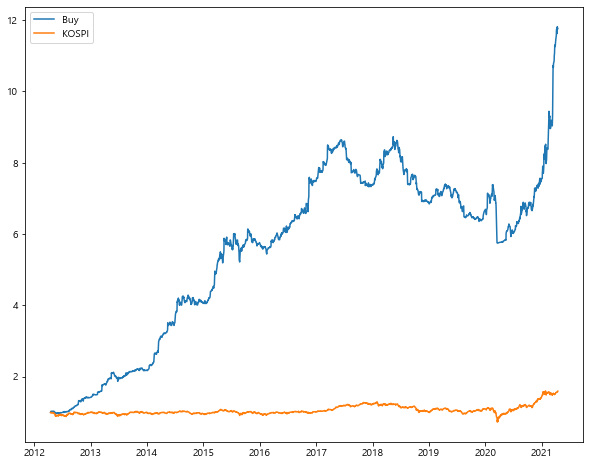

withMomentumYear


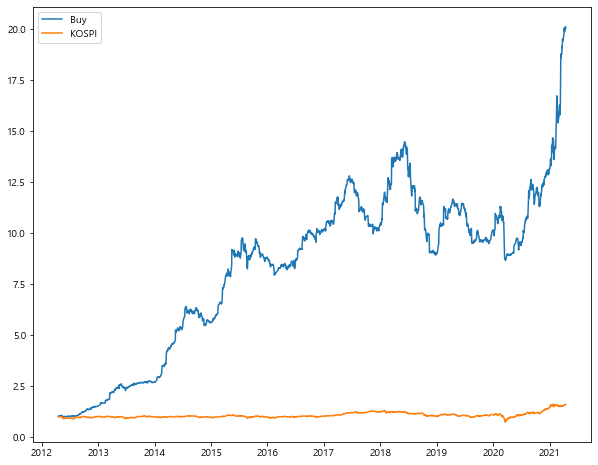

In [213]:
for case in case_dic.keys():
    print(case)
    DrawingSimpleGraph(case_dic[case])

# 간단한 계산

In [ ]:
# empyrical/stats/py 참조 가능

In [175]:
def simple_analyzer (data : pd.DataFrame):
    analysis_result = pd.DataFrame(columns = data.columns, index = ['Total Profit','CAGR','MDD','Std','Sharpe_Ratio'])
    trade_year = len(data)/252
#     print(trade_year)

#     if 'KOSPI' in data.columns:
#         total_profit = df_yield['KOSPI'].cumprod()[-1]
#         cagr_kospi = round((total_profit ** (1/trade_year)-1)*100,2)
#     else:
#         cagr_kospi = 0
    
    for col in data.columns:
    
        total_profit = data[col].cumprod()[-1]
        cagr = round((total_profit ** (1/trade_year)-1)*100,2)

        arr_v = np.array(data[col].cumprod())
        peak_lower = np.argmax(np.maximum.accumulate(arr_v)-arr_v)
        peak_upper = np.argmax(arr_v[:peak_lower])
        mdd = round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper] * 100 , 3)

        std = round(data[col].std()*(252**0.5)*100,2)
        
        risk_free_rate = 0
        sharpe_ratio = (cagr-risk_free_rate) / std
        
        analysis_result[col] = [total_profit,cagr,mdd,std,sharpe_ratio]
    return analysis_result

In [205]:
def simple_analyzer_yearly (data : pd.DataFrame):
    if not isinstance(data.index[0],datetime):
        data.index = [date_to_date(date) for date in data.index]
    analyze_result_yearly = {}
    for code in data.columns:
        year_range = range(data.index[0].year,data.index[-1].year+1)
        analyze_result = pd.DataFrame(columns = year_range, index = ['CAGR','MDD','Std','Sharpe_Ratio'])
        for year in year_range:
            data_year = data.loc[datetime(year,1,1):datetime(year,12,31),['Buy']]
            analyze_result[year] = simple_analyzer(data_year)['Buy'][1:]
        analyze_result_yearly[code] = analyze_result
    return analyze_result_yearly

In [197]:
def simple_analyzer_monthly_return (data : pd.DataFrame):
    if not isinstance(data.index[0],datetime):
        data.index = [date_to_date(date) for date in data.index]
    
    year_range = range(data.index[0].year,data.index[-1].year+1)
    month_range = range(1,13)
    analyze_result_monthly = {}
    for code in data.columns:
        
        analyze_result = pd.DataFrame(columns = month_range, index = year_range)
        for month in month_range:
            monthly_return_list = []
            for year in year_range:
                data_month = data.loc[datetime(year,month,1):datetime(year,month,1)+relativedelta(months=1)-relativedelta(days=1),code]
                if len(data_month) == 0:
                    return_month = float('nan')
                else:
                    return_month = data_month.cumprod()[-1]
                monthly_return_list.append(return_month)
            analyze_result[month] = monthly_return_list
        analyze_result_monthly[code] = analyze_result
    return analyze_result_monthly

In [204]:
for case in case_dic.keys():
    print(case)
    display(simple_analyzer(case_dic[case].iloc[1:,:]))

withoutMomentumYear


,Buy,KOSPI
Total Profit,11.744163,1.606237
CAGR,32.360000,5.540000
MDD,-34.196000,-43.819000
Std,16.680000,15.430000
Sharpe_Ratio,1.940048,0.359041


withMomentumYear


,Buy,KOSPI
Total Profit,19.892746,1.606237
CAGR,40.550000,5.540000
MDD,-40.146000,-43.819000
Std,21.820000,15.430000
Sharpe_Ratio,1.858387,0.359041


In [209]:
case_dic['withoutMomentumYear'].loc['2021-01-01':,['Buy']]

,Buy
2021-01-04,1.001302
2021-01-05,1.023139
2021-01-06,1.005480
2021-01-07,1.016281
2021-01-08,0.999901
...,...
2021-04-09,1.013338
2021-04-12,1.003634
2021-04-13,0.996315
2021-04-14,0.999260


In [206]:
# display(simple_analyzer_monthly_return(case_dic['withoutMomentumYear'].loc[:,['Buy']]))
display(simple_analyzer_yearly(case_dic['withoutMomentumYear'])['Buy'])

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
CAGR,63.590000,55.840000,89.040000,42.900000,30.570000,-1.320000,-6.730000,-3.710000,13.810000,382.130000
MDD,-7.688000,-12.040000,-6.492000,-13.262000,-4.740000,-15.255000,-21.156000,-14.184000,-22.217000,-6.373000
Std,16.380000,17.270000,20.800000,17.770000,12.460000,9.420000,13.390000,8.690000,18.670000,36.610000
Sharpe_Ratio,3.882173,3.233353,4.280769,2.414181,2.453451,-0.140127,-0.502614,-0.426928,0.739689,10.437859


In [207]:
# case_dic['withoutMomentumYear'].loc[:,['KOSPI']]
display(simple_analyzer_yearly(case_dic['withMomentumYear'])['Buy'])

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
CAGR,79.840000,80.640000,112.180000,58.580000,15.690000,2.110000,-13.510000,12.210000,30.870000,346.350000
MDD,-8.942000,-12.915000,-14.803000,-15.512000,-8.954000,-22.246000,-38.425000,-18.785000,-23.321000,-7.912000
Std,16.780000,22.380000,26.680000,21.530000,13.010000,14.300000,26.730000,17.410000,22.600000,40.760000
Sharpe_Ratio,4.758045,3.603217,4.204648,2.720855,1.205995,0.147552,-0.505425,0.701321,1.365929,8.497301


In [39]:
for case in case_dic.keys():
    print(case)
    display(simple_analyzer(case_dic[case]))

withoutMomentumYear


,Buy,2,3,4,Sell,KOSPI
Total Profit,5.056253,3.461733,2.748241,1.569011,1.152849,1.593227
CAGR,20.250000,15.170000,12.190000,5.260000,1.630000,5.440000
MDD,-52.023000,-51.216000,-50.632000,-54.688000,-57.841000,-43.819000
Std,17.930000,17.070000,16.570000,16.210000,17.160000,15.420000
Sharpe_Ratio,1.129392,0.888694,0.735667,0.324491,0.094988,0.352789


withMomentumYear


,Buy,2,3,4,Sell,KOSPI
Total Profit,4.617206,3.246174,1.973358,2.286227,1.285023,1.593227
CAGR,19.010000,14.330000,8.040000,9.860000,2.890000,5.440000
MDD,-52.389000,-45.200000,-59.434000,-50.276000,-54.535000,-43.819000
Std,18.290000,16.620000,16.520000,16.330000,17.290000,15.420000
Sharpe_Ratio,1.039366,0.862214,0.486683,0.603797,0.167149,0.352789


기타코드

In [ ]:
# 우선주 등 제외하기
# stock_code_list 정제하기 (우선주, 리츠, 옵션) -> 6자리 숫자만, 맨 앞자리에 0 들어가는 것만
import re
stock_code_list = []
for stock_code in df_cap.index:
    stock_code = re.findall("\d+", stock_code)[0] # 숫자만 추출한 뒤 첫번째 것만 사용
    if (stock_code[-1] == '0') and (len(stock_code) == 6):
        stock_code_list.append(stock_code)
len(stock_code_list)

In [ ]:
from collections import Counter
a = Counter(df_yield.index.to_list())
a.most_common()

In [ ]:
df_yield[df_yield.index == '2010-02-01']

In [ ]:
buy = datetime(2010,1,1)
momen = 5
gap = 1
duration_stock_estimation = 11
duration_stock_selection = 3
duration_trade = 1 #매월 rebalancing
discrete = 3
cap = 3

In [ ]:
# Momentum 지표 사용
start = datetime(2010,1,1)
change = change_all
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    stock_list = make_stock_list_by_date(buy)
    stock_list_by_yield = make_stock_list_by_yield(stock_list, bgn=buy-relativedelta(months = gap+duration_stock_estimation),
                                                   end=buy-relativedelta(months = gap))
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
        df_yield_partial = pd.DataFrame()
        # momentum기준으로 나눈 그룹마다 계산
        for k in range(momen):
            stock_list_temp = stock_list_by_yield[int(len(stock_list_by_yield)/(momen)*k):int(len(stock_list_by_yield)/(momen)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'Low',4:'High'},inplace=True)

In [ ]:
# 시가총액 + Momentum 지표 사용
start = datetime(2010,1,1)
change = change_all
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    # 시가총액기준 & 시가총액 높은것부터 정렬
    stock_list_by_cap = make_stock_list_by_date_cap(buy)
    # Momentum 지표 낮은것부터 정렬
    stock_list_by_yield = []
    for part in range(cap):
        stock_list_temp_partial = stock_list_by_cap[int(len(stock_list_by_cap)/cap*part):int(len(stock_list_by_cap)/cap*(part+1))]
        stock_list_temp_partial = make_stock_list_by_yield(stock_list_temp_partial, bgn=buy-relativedelta(months = gap+duration_stock_estimation),
                                                          end=buy-relativedelta(months = gap))
        stock_list_by_yield = stock_list_by_yield + list(stock_list_temp_partial)
    
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
        df_yield_partial = pd.DataFrame()
        for k in range(cap*momen):
            stock_list_temp = stock_list_by_yield[int(len(stock_list_by_yield)/(cap*momen)*k):int(len(stock_list_by_yield)/(cap*momen)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'High Cap Low Momen',4:'High Cap High Momen',10:'Low Cap Low Momen',14:'Low Cap High Momen'},inplace=True)

In [ ]:
# Momentum 지표 + discrete 지표 사용
start = datetime(2010,1,1)
change = change_all
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    stock_list = make_stock_list_by_date(buy)
    stock_list_by_yield = make_stock_list_by_yield(stock_list, bgn=buy-relativedelta(months = gap+duration_stock_estimation),
                                                   end=buy-relativedelta(months = gap))
    # partial로 구분된 stock_list를 각각 discrete기준으로 재정렬
    stock_list_by_yield_discrete = []
    for part in range(momen):
        stock_list_temp_partial = stock_list_by_yield[int(len(stock_list_by_yield)/momen*part):int(len(stock_list_by_yield)/momen*(part+1))]
        stock_list_temp_partial = make_stock_list_by_discrete(stock_list_temp_partial, bgn=buy-relativedelta(months = gap+duration_stock_estimation), 
                                                              end=buy-relativedelta(months = gap))
        stock_list_by_yield_discrete = stock_list_by_yield_discrete + list(stock_list_temp_partial)
    stock_list_by_yield = stock_list_by_yield_discrete
    
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
#         yield_list = []
        df_yield_partial = pd.DataFrame()
        for k in range(momen*discrete):
            stock_list_temp = stock_list_by_yield[int(len(stock_list_by_yield)/(momen*discrete)*k):int(len(stock_list_by_yield)/(momen*discrete)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'Low_Discrete',2:'Low_Continuous',12:'High_Discrete',14:'High_Continuous'},inplace=True)

In [ ]:
# Quality 지표
start = datetime(2010,1,1)
change = change_all
finance = finance_kospi
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    date_buy = buy
    period = define_period(date_buy)
    
    stock_list = make_stock_list_by_finance(date=date_buy, period=period, fs=finance, value_factors=[], quality_factors=['GP/A'])
    print(buy, len(stock_list))
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
        df_yield_partial = pd.DataFrame()
        # momentum기준으로 나눈 그룹마다 계산
        for k in range(momen):
#             print(k)
            stock_list_temp = stock_list[int(len(stock_list)/(momen)*k):int(len(stock_list)/(momen)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'Good',4:'Bad'},inplace=True)